***2120192797-亓志强-基于人口普查数据的收入预测模型构建及比较分析***

数据来自UCI的(Adult Data Set)[https://archive.ics.uci.edu/ml/datasets/adult]数据集，该数据集包括三个文件，`adult.names`为数据集的说明文件，包括数据来源以及各指标的名称和说明。
`adult.data`和`adult.test`分别为已分割好的训练集和测试集，本文将这两个数据集进行合并，在处理的过程中重新划分样本的训练集和测试集。

In [1]:
# 控制页面大小
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))  # 宽度100%
# display(HTML("<style>.container {}</style>"))  # 恢复正常

# 导入数据包

In [2]:
## 导入相关数据包
# 数据处理
import time, datetime, math, random
from io import StringIO
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 可视化
import matplotlib.pyplot as plt  # 绘图
import missingno  # 缺失值可视化
import seaborn as sns  # 绘图库
from pandas.plotting import scatter_matrix #绘制散布矩阵图
# from mpl_toolkits.mplot3d import Axes3D #绘制三维图

# 分类模型
# import sklearn.ensemble as ske # 包含了一套分类算法
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import VotingClassifier 
from sklearn.svm import SVC
# from sklearn.svm import LinearSVC

# 自动调参器 - 随机探索
import scipy.stats as st
from scipy.stats import randint as sp_randint # 随机变量
# from sklearn.model_selection import GridSearchCV # 自动调参工具（网格搜索）
from sklearn.model_selection import RandomizedSearchCV # 自动调参工具（随机采样）

# 计算模型评价指标
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score

# 控制提示信息
import warnings
warnings.filterwarnings('ignore')

# 便于在notebook中显示图形并可省略plt.show()，简化代码
%matplotlib inline


# 导入数据集

In [3]:
## 载入原始样本的训练集和测试集
# 本题目数据不含标题行，缺失值在文件中用？表示，测试集首行非数据需剔除
headers = ['age', 'workclass', 'final-weight', 
           'education', 'education-num', 
           'marital-status', 'occupation', 
           'relationship', 'race', 'sex', 
           'capital-gain', 'capital-loss', 
           'hours-per-week', 'country', 
           'income-level']  # 定义数据表头即参数名
# headers = ['年龄', '工作类型', '权重', 
#            '受教育程度', '受教育时长', 
#            '婚姻情况', '职业', 
#            '家庭角色', '种族', '性别', 
#            '资本收益', '资本支出', 
#            '周工作小时数', '国籍', 
#            '收入等级']
adult_data = pd.read_csv('dataset/adult.data', 
                       header=None, 
                       names=headers, 
                       sep=',\s', 
                       na_values=["?"], 
                       engine='python')  # 导入数据集给出的训练集
adult_test = pd.read_csv('dataset/adult.test', 
                      header=None, 
                      names=headers, 
                      sep=',\s', 
                      na_values=["?"], 
                      engine='python', 
                      skiprows=1)  # 导入数据集给出的测试集

In [4]:
## 合并两个数据集
dataset = adult_data.append(adult_test)
# 由于导入时分别为两数据集添加了索引，故对合并后的DataFrame重新创建索引并覆盖原索引
dataset.reset_index(inplace=True, drop=True)

# 数据预处理

## 处理缺失值

### 查看数据缺失分布情况

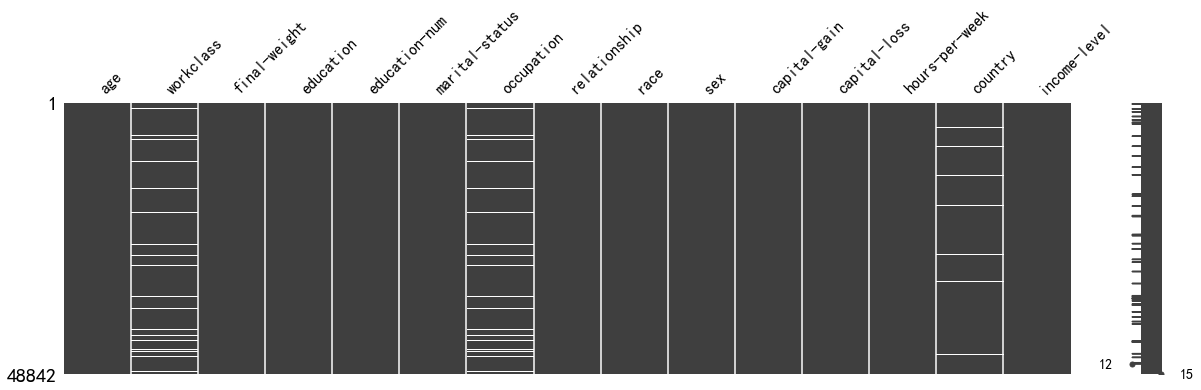

In [5]:
# 查看缺失值分布情况
missingno.matrix(dataset, figsize = (20,5))

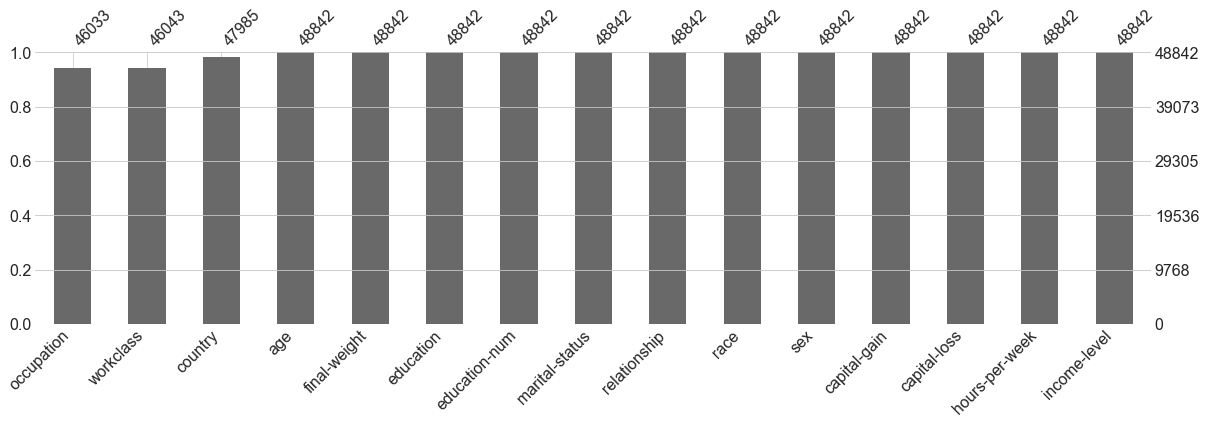

In [6]:
# 创建缺失值统计条形图并按缺失数量升序排列
plt.style.use('seaborn-whitegrid')
missingno.bar(dataset, sort='ascending', figsize = (20,5)) 

In [7]:
dataset.describe(include='all')

,age,workclass,final-weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,income-level
count,48842.000000,46043,4.884200e+04,48842,48842.000000,48842,46033,48842,48842,48842,48842.000000,48842.000000,48842.000000,47985,48842
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,4
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,33906,NaN,15784,NaN,22379,6172,19716,41762,32650,NaN,NaN,NaN,43832,24720
mean,38.643585,NaN,1.896641e+05,NaN,10.078089,NaN,NaN,NaN,NaN,NaN,1079.067626,87.502314,40.422382,NaN,NaN
std,13.710510,NaN,1.056040e+05,NaN,2.570973,NaN,NaN,NaN,NaN,NaN,7452.019058,403.004552,12.391444,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.175505e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.781445e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.376420e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


数据集共包含48842个样本，其中occupation、workclass、country三个指标存在缺失值。

### 处理缺失样本

In [8]:
dataset.dropna(axis=0, how='any', inplace=True)
dataset.describe(include='all')

,age,workclass,final-weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,income-level
count,45222.000000,45222,4.522200e+04,45222,45222.000000,45222,45222,45222,45222,45222,45222.000000,45222.000000,45222.000000,45222,45222
unique,NaN,7,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,4
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Craft-repair,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,33307,NaN,14783,NaN,21055,6020,18666,38903,30527,NaN,NaN,NaN,41292,22654
mean,38.547941,NaN,1.897347e+05,NaN,10.118460,NaN,NaN,NaN,NaN,NaN,1101.430344,88.595418,40.938017,NaN,NaN
std,13.217870,NaN,1.056392e+05,NaN,2.552881,NaN,NaN,NaN,NaN,NaN,7506.430084,404.956092,12.007508,NaN,NaN
min,17.000000,NaN,1.349200e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.173882e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783160e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,47.000000,NaN,2.379260e+05,NaN,13.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


由于本题目数据量较为充足，含有缺失值的样本也较少，故采取直接删除含缺失值样本的方式对缺失值进行处理。
处理后共删除48842-45222=3620个样本，剩余45222个有效样本

## 处理数据异常

In [9]:
# 处理年收入指标
# 由于年收入指标存在四种值，‘>50K’，‘>50K.’，‘<=50K’，‘<=50K.’，故本题中将‘>50K’和‘>50K.’，‘<=50K’和‘<=50K.’合并
dataset.loc[dataset['income-level'] == '>50K.', 'income-level'] = '>50K'
dataset.loc[dataset['income-level'] == '<=50K.', 'income-level'] = '<=50K'

# 删除无用的final-weight指标
dataset = dataset.drop(['final-weight'],axis=1)

## 对数据整体进行描述

In [10]:
# 预览数据
dataset.head(5) # 前5行
# dataset.tail(5) # 后5行

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,income-level
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [11]:
# 对数值变量进行描述
dataset.describe(include='all')

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,income-level
count,45222.000000,45222,45222,45222.000000,45222,45222,45222,45222,45222,45222.000000,45222.000000,45222.000000,45222,45222
unique,NaN,7,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,HS-grad,NaN,Married-civ-spouse,Craft-repair,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,33307,14783,NaN,21055,6020,18666,38903,30527,NaN,NaN,NaN,41292,34014
mean,38.547941,NaN,NaN,10.118460,NaN,NaN,NaN,NaN,NaN,1101.430344,88.595418,40.938017,NaN,NaN
std,13.217870,NaN,NaN,2.552881,NaN,NaN,NaN,NaN,NaN,7506.430084,404.956092,12.007508,NaN,NaN
min,17.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,47.000000,NaN,NaN,13.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


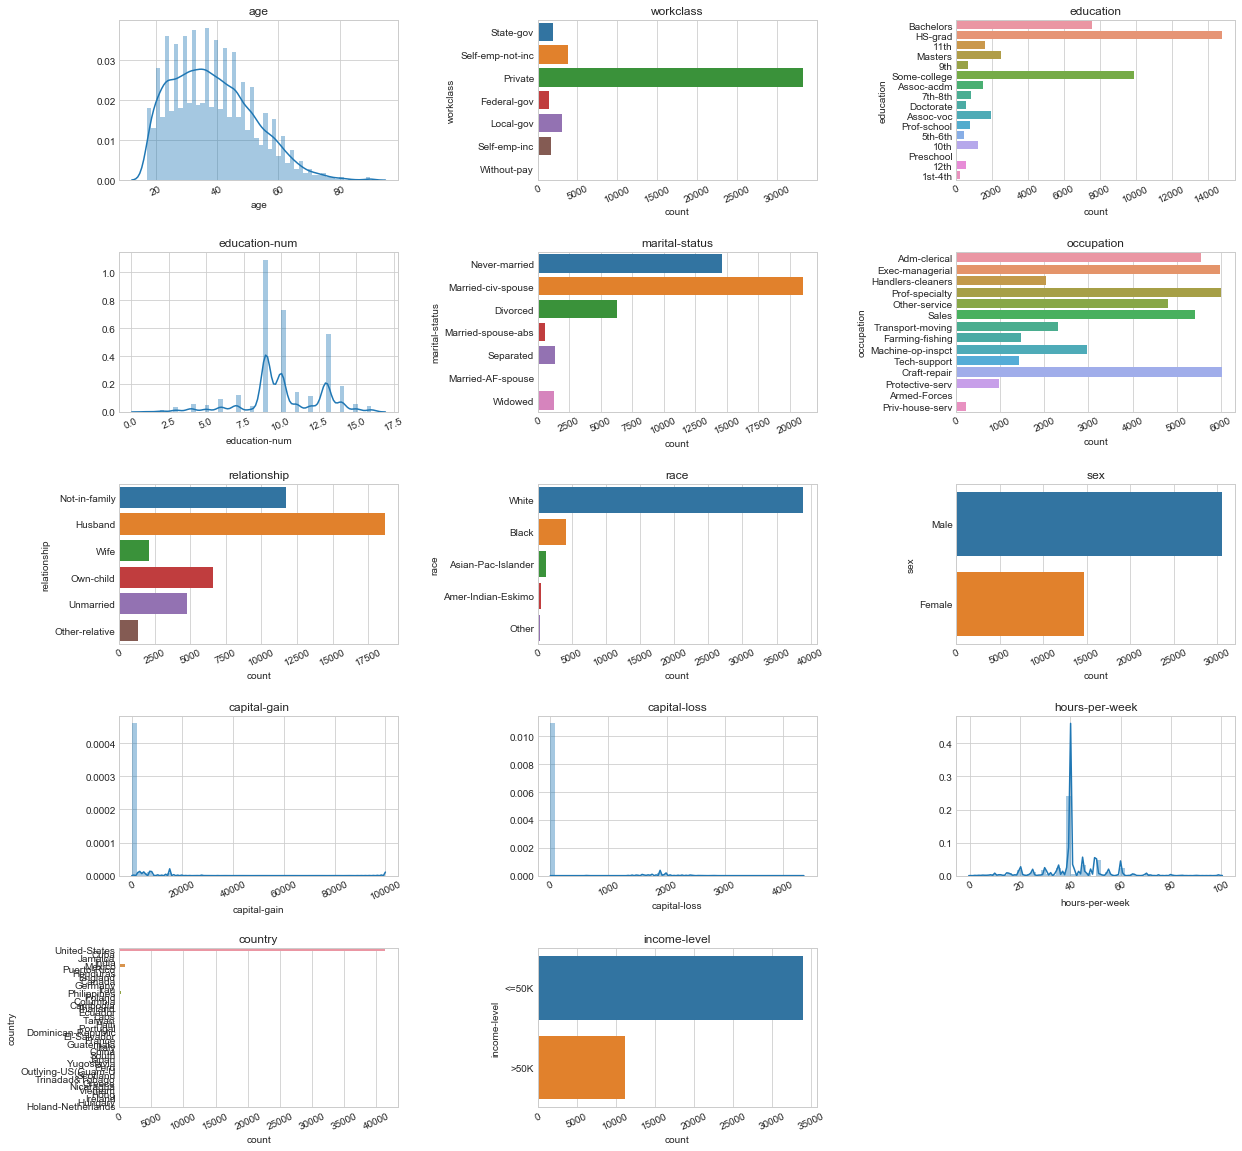

In [12]:
# 绘制每个变量的分布状况
def plot_distribution(dataset, cols, width, height, hspace, wspace):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(dataset, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

## 对各个离散型指标进行分析

本文所用的数据涉及多个分类变量，下面将对这些变量进行检查和处理

### 工作类型
本文数据集共有8种数据类型：私人（Private）、自由职业非公司（Self-emp-not-inc）、自由职业公司（Self-emp-inc）、联邦政府（Federal-gov）、地方政府（Local-gov）、州政府（State-gov）、无薪（Without-pay）、无工作经验（Never-worked）；

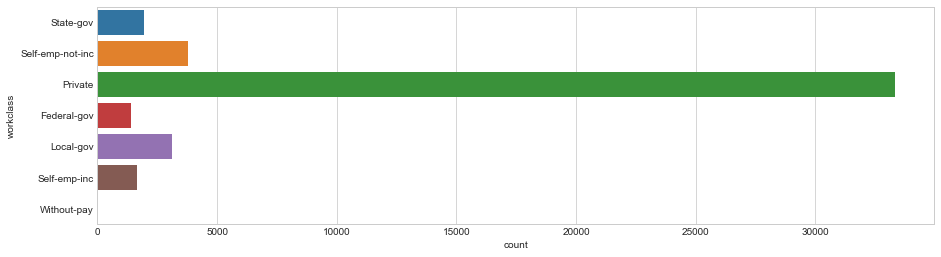

In [13]:
# 工作类型
# 私营工作在样本中占比较大，不工作和无收入工作样本数量极小
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15,4)) 
sns.countplot(y="workclass", data=dataset);

In [14]:
# 根据上述数据分布情况和实际考虑，将上述8种类型的工作类型分为5类：
dataset.loc[dataset['workclass'] == 'Without-pay', 'workclass'] = 'Not Working'
dataset.loc[dataset['workclass'] == 'Never-worked', 'workclass'] = 'Not Working'
dataset.loc[dataset['workclass'] == 'Federal-gov', 'workclass'] = 'Fed-gov'
dataset.loc[dataset['workclass'] == 'State-gov', 'workclass'] = 'Non-fed-gov'
dataset.loc[dataset['workclass'] == 'Local-gov', 'workclass'] = 'Non-fed-gov'
dataset.loc[dataset['workclass'] == 'Self-emp-not-inc', 'workclass'] = 'Self-emp'
dataset.loc[dataset['workclass'] == 'Self-emp-inc', 'workclass'] = 'Self-emp'
dataset.loc[dataset['workclass'] == 'Private', 'workclass'] = 'Private'

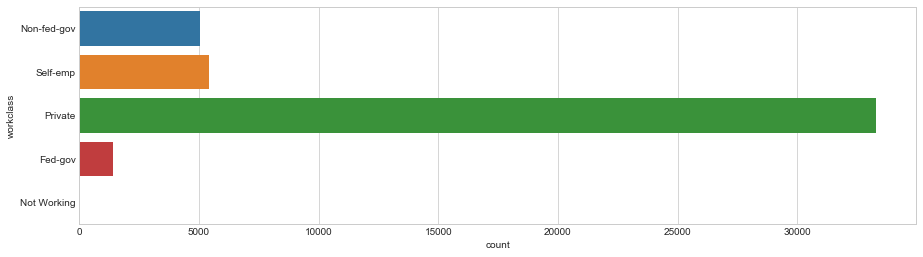

In [15]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,4)) 
sns.countplot(y="workclass", data=dataset);

### 职业

本数据集中职业共有14种类型如下：

Tech-support（技术支持）, Craft-repair（手工艺维修）, Other-service（其他职业）,Sales（销售）, Exec-managerial（执行主管）, Prof-specialty（专业技术）,Handlers-cleaners（劳工保洁）, Machine-op-inspct（机械操作）, Adm-clerical（管理文书）,Farming-fishing（农业捕捞）, Transport-moving（运输）, Priv-house-serv（家政服务）,Protective-serv（保安）, Armed-Forces（军人）

为便于后续分析，将其合并为

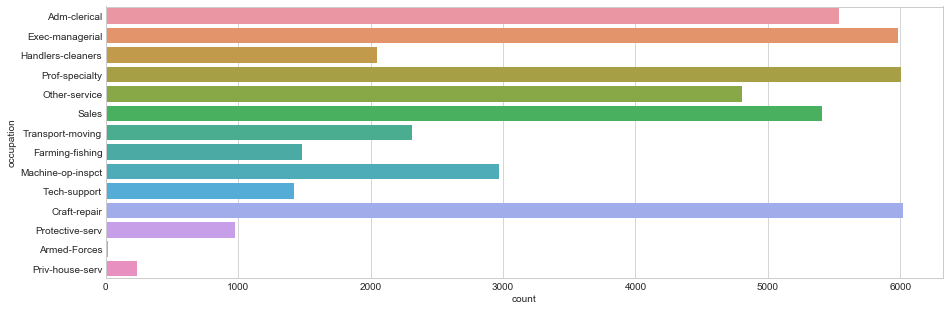

In [16]:
## 职业
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15,5)) 
sns.countplot(y="occupation", data=dataset);

In [17]:
# 职业共存在14类，按职业类型进行归纳并划分为
# 
dataset.loc[dataset['occupation'] == 'Adm-clerical', 'occupation'] = 'Admin'  # 行政文员
dataset.loc[dataset['occupation'] == 'Armed-Forces', 'occupation'] = 'Military'  # 军队
dataset.loc[dataset['occupation'] == 'Protective-serv', 'occupation'] = 'Military'  # 军队
dataset.loc[dataset['occupation'] == 'Craft-repair', 'occupation'] = 'Manual Labour'  # 体力劳动者
dataset.loc[dataset['occupation'] == 'Transport-moving', 'occupation'] = 'Manual Labour'  # 体力劳动者
dataset.loc[dataset['occupation'] == 'Farming-fishing', 'occupation'] = 'Manual Labour'  # 体力劳动者
dataset.loc[dataset['occupation'] == 'Handlers-cleaners', 'occupation'] = 'Manual Labour'  # 体力劳动者
dataset.loc[dataset['occupation'] == 'Machine-op-inspct', 'occupation'] = 'Manual Labour'  # 体力劳动者
dataset.loc[dataset['occupation'] == 'Exec-managerial', 'occupation'] = 'Office Labour'  # 文书工作
dataset.loc[dataset['occupation'] == 'Sales', 'occupation'] = 'Office Labour'  # 文书工作
dataset.loc[dataset['occupation'] == 'Tech-support', 'occupation'] = 'Office Labour'  # 文书工作
dataset.loc[dataset['occupation'] == 'Other-service', 'occupation'] = 'Service'  # 服务人员
dataset.loc[dataset['occupation'] == 'Priv-house-serv', 'occupation'] = 'Service'  # 服务人员
dataset.loc[dataset['occupation'] == 'Prof-specialty', 'occupation'] = 'Professional'  # 技术人员

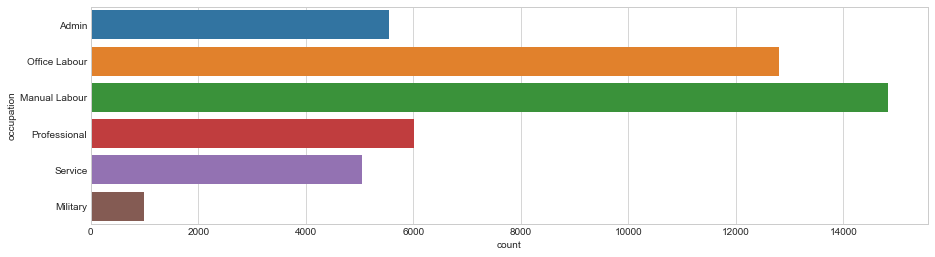

In [18]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,4))
sns.countplot(y="occupation", data=dataset);

### 国籍

数据说明里共列出41个国家和地区，除美国外大部分国家和地区的样本都很少，故在此按照地域对这些国家和地区进行合并

United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

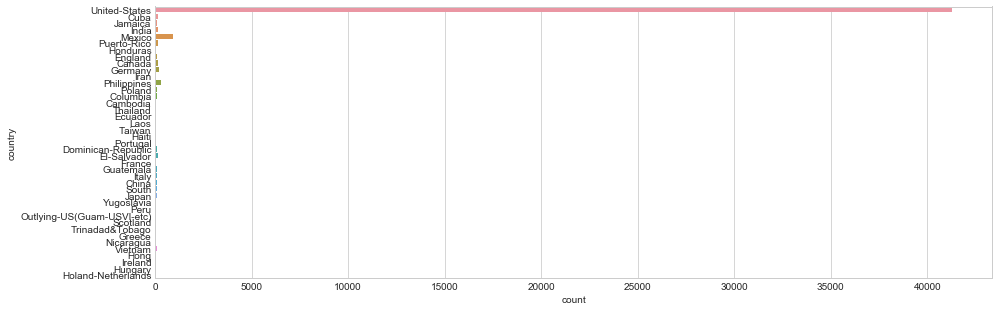

In [19]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15,5)) 
sns.countplot(y="country", data=dataset);

In [20]:
dataset.loc[dataset['country'] == 'China'                       , 'country'] = 'East-Asia'
dataset.loc[dataset['country'] == 'Hong'                        , 'country'] = 'East-Asia'
dataset.loc[dataset['country'] == 'Taiwan'                      , 'country'] = 'East-Asia'
dataset.loc[dataset['country'] == 'Japan'                       , 'country'] = 'East-Asia'

dataset.loc[dataset['country'] == 'Thailand'                    , 'country'] = 'Southeast-Asia'
dataset.loc[dataset['country'] == 'Vietnam'                     , 'country'] = 'Southeast-Asia'
dataset.loc[dataset['country'] == 'Laos'                        , 'country'] = 'Southeast-Asia'
dataset.loc[dataset['country'] == 'Philippines'                 , 'country'] = 'Southeast-Asia'
dataset.loc[dataset['country'] == 'Cambodia'                    , 'country'] = 'Southeast-Asia'

dataset.loc[dataset['country'] == 'Columbia'                    , 'country'] = 'South-America'    
dataset.loc[dataset['country'] == 'Cuba'                        , 'country'] = 'South-America'        
dataset.loc[dataset['country'] == 'Dominican-Republic'          , 'country'] = 'South-America'
dataset.loc[dataset['country'] == 'Ecuador'                     , 'country'] = 'South-America'     
dataset.loc[dataset['country'] == 'Guatemala'                   , 'country'] = 'South-America'
dataset.loc[dataset['country'] == 'El-Salvador'                 , 'country'] = 'South-America' 
dataset.loc[dataset['country'] == 'Haiti'                       , 'country'] = 'South-America'
dataset.loc[dataset['country'] == 'Honduras'                    , 'country'] = 'South-America'
dataset.loc[dataset['country'] == 'Mexico'                      , 'country'] = 'South-America'
dataset.loc[dataset['country'] == 'Nicaragua'                   , 'country'] = 'South-America'
dataset.loc[dataset['country'] == 'Outlying-US(Guam-USVI-etc)'  , 'country'] = 'South-America'
dataset.loc[dataset['country'] == 'Peru'                        , 'country'] = 'South-America'
dataset.loc[dataset['country'] == 'Jamaica'                     , 'country'] = 'South-America'
dataset.loc[dataset['country'] == 'Puerto-Rico'                 , 'country'] = 'South-America'
dataset.loc[dataset['country'] == 'Trinadad&Tobago'             , 'country'] = 'South-America'

dataset.loc[dataset['country'] == 'Canada'                      , 'country'] = 'British-Commonwealth'    
dataset.loc[dataset['country'] == 'England'                     , 'country'] = 'British-Commonwealth'
dataset.loc[dataset['country'] == 'India'                       , 'country'] = 'British-Commonwealth'
dataset.loc[dataset['country'] == 'Ireland'                     , 'country'] = 'British-Commonwealth'
dataset.loc[dataset['country'] == 'Scotland'                    , 'country'] = 'British-Commonwealth'

dataset.loc[dataset['country'] == 'France'                      , 'country'] = 'Europe'
dataset.loc[dataset['country'] == 'Germany'                     , 'country'] = 'Europe'
dataset.loc[dataset['country'] == 'Italy'                       , 'country'] = 'Europe'
dataset.loc[dataset['country'] == 'Holand-Netherlands'          , 'country'] = 'Europe'
dataset.loc[dataset['country'] == 'Greece'                      , 'country'] = 'Europe'
dataset.loc[dataset['country'] == 'Hungary'                     , 'country'] = 'Europe'
dataset.loc[dataset['country'] == 'Iran'                        , 'country'] = 'Europe'
dataset.loc[dataset['country'] == 'Yugoslavia'                  , 'country'] = 'Europe'
dataset.loc[dataset['country'] == 'Poland'                      , 'country'] = 'Europe'
dataset.loc[dataset['country'] == 'Portugal'                    , 'country'] = 'Europe'
dataset.loc[dataset['country'] == 'South'                       , 'country'] = 'Europe'

dataset.loc[dataset['country'] == 'United-States'               , 'country'] = 'United-States'

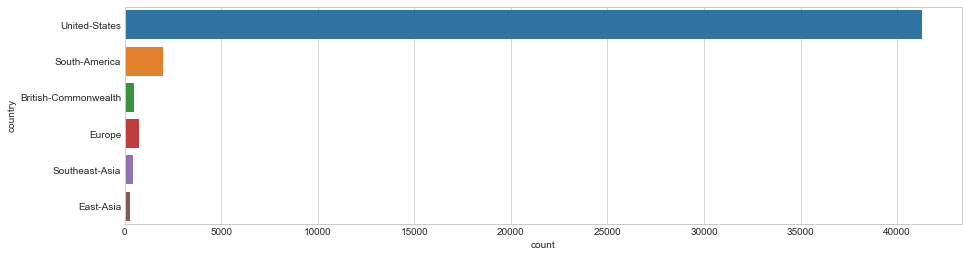

In [21]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,4)) 
sns.countplot(y="country", data=dataset);

### 受教育程度

受教育程度共有16个类别，在此按照等级进行合并以简化分析

Bachelors（学士）, Some-college（大学未毕业）, 11th（高二）, HS-grad（高中毕业）,Prof-school（职业学校）, Assoc-acdm（大学专科）, Assoc-voc（准职业学位）, 9th（初三）,7th-8th（初中一、二年级）, 12th（高三）, Masters（硕士）, 1st-4th（小学1-4年级）, 10th（高一）, Doctorate（博士）, 5th-6th（小学5、6年级）, Preschool（幼儿园）.

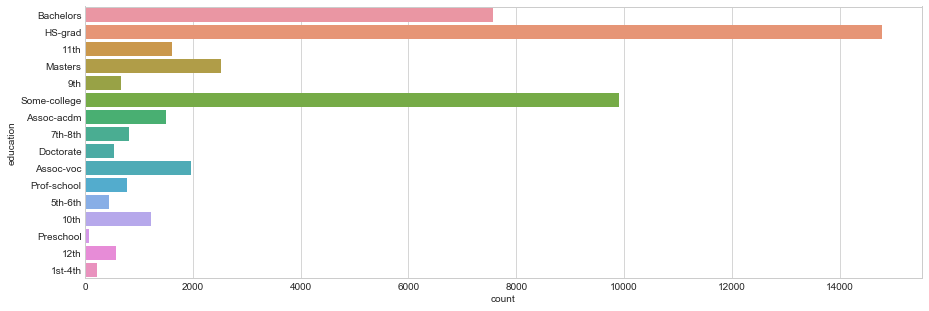

In [22]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15,5)) 
sns.countplot(y="education", data=dataset);

In [23]:
dataset.loc[dataset['education'] == 'Preschool'     , 'education'] = 'Dropout'  # 退学
dataset.loc[dataset['education'] == '1st-4th'       , 'education'] = 'Dropout'  # 退学
dataset.loc[dataset['education'] == '5th-6th'       , 'education'] = 'Dropout'  # 退学
dataset.loc[dataset['education'] == '7th-8th'       , 'education'] = 'Dropout'  # 退学
dataset.loc[dataset['education'] == '9th'           , 'education'] = 'Dropout'  # 退学
dataset.loc[dataset['education'] == '10th'          , 'education'] = 'Dropout'  # 退学
dataset.loc[dataset['education'] == '11th'          , 'education'] = 'Dropout'  # 退学
dataset.loc[dataset['education'] == '12th'          , 'education'] = 'Dropout'  # 退学
dataset.loc[dataset['education'] == 'Assoc-acdm'    , 'education'] = 'Associate'  # 专科
dataset.loc[dataset['education'] == 'Assoc-voc'     , 'education'] = 'Associate'  # 专科
dataset.loc[dataset['education'] == 'HS-Grad'       , 'education'] = 'HS-Graduate'  # 高中
dataset.loc[dataset['education'] == 'Some-college'  , 'education'] = 'HS-Graduate'  # 高中
dataset.loc[dataset['education'] == 'Prof-school'   , 'education'] = 'Professor'  # 职业
dataset.loc[dataset['education'] == 'Bachelors'     , 'education'] = 'Bachelors'  # 学士
dataset.loc[dataset['education'] == 'Masters'       , 'education'] = 'Masters'  # 硕士
dataset.loc[dataset['education'] == 'Doctorate'     , 'education'] = 'Doctorate'  # 博士


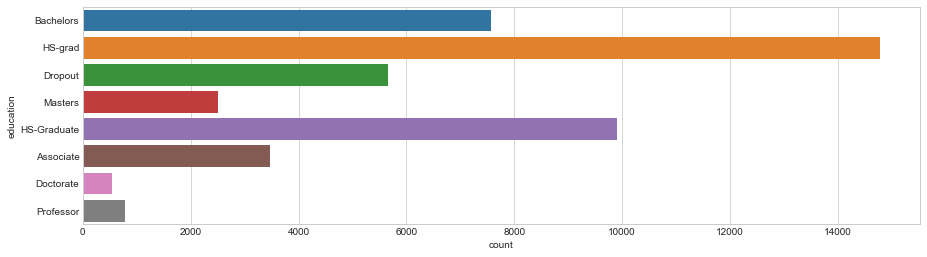

In [24]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15,4)) 
sns.countplot(y="education", data=dataset);

### 婚姻状态

数据说明里共列出7种婚姻状态Married-civ-spouse（已婚平民配偶）, Divorced（离婚）, Never-married（未婚）, Separated（分居）, Widowed（丧偶）, Married-spouse-absent（已婚配偶异地）, arried-AF-spouse（已婚军属）

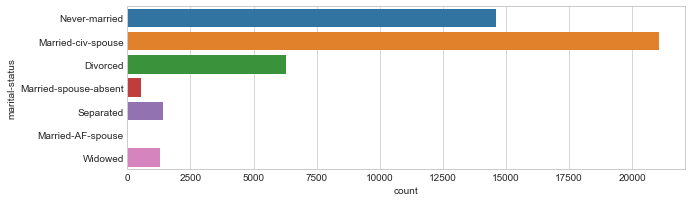

In [25]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,3)) 
sns.countplot(y="marital-status", data=dataset);

In [26]:
dataset.loc[dataset['marital-status'] == 'Never-married'        , 'marital-status'] = 'Never-Married'  # 从未结婚
dataset.loc[dataset['marital-status'] == 'Divorced'             , 'marital-status'] = 'Divorced'  # 离异
dataset.loc[dataset['marital-status'] == 'Widowed'              , 'marital-status'] = 'Widowed'  # 丧偶
dataset.loc[dataset['marital-status'] == 'Married-spouse-absent', 'marital-status'] = 'Separated'  # 分居
dataset.loc[dataset['marital-status'] == 'Separated'            , 'marital-status'] = 'Separated'  # 分居
dataset.loc[dataset['marital-status'] == 'Married-AF-spouse'    , 'marital-status'] = 'Married'  # 已婚
dataset.loc[dataset['marital-status'] == 'Married-civ-spouse'   , 'marital-status'] = 'Married'  # 已婚

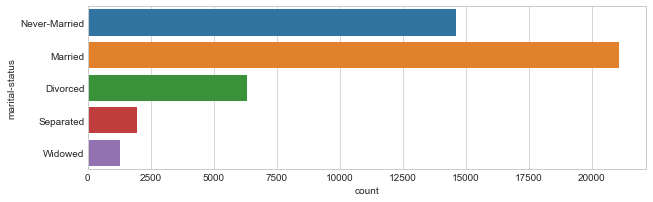

In [27]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,3)) 
sns.countplot(y="marital-status", data=dataset);

### 查看各指标分布情况

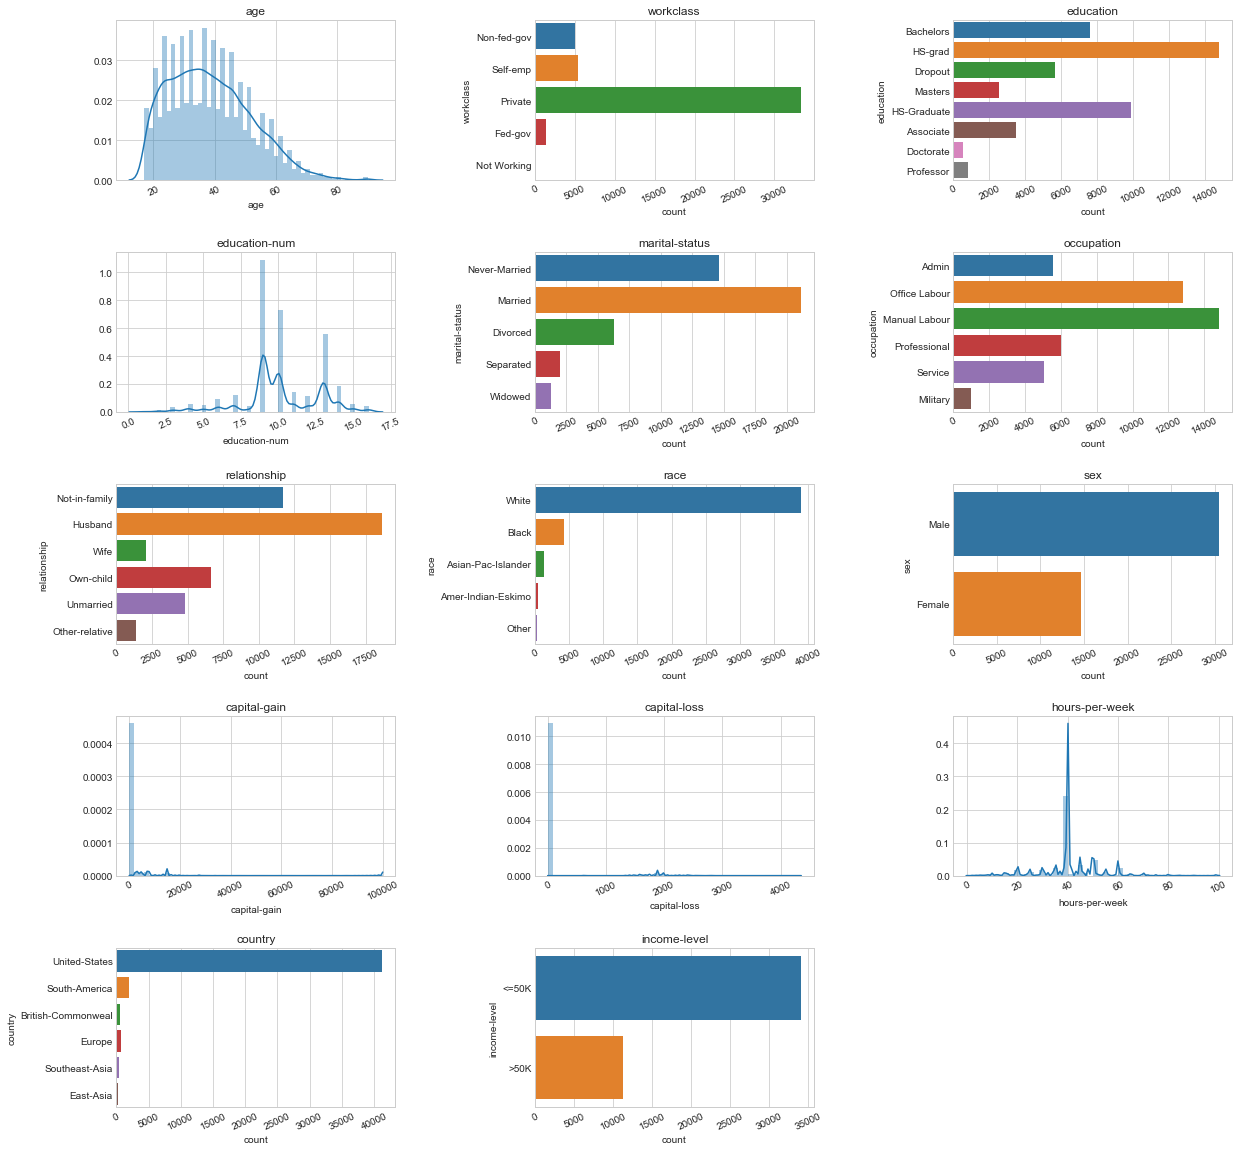

In [28]:
# def plot_distribution(dataset, cols, width, height, hspace, wspace):
#     plt.style.use('seaborn-whitegrid')
#     fig = plt.figure(figsize=(width,height))
#     fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
#     rows = math.ceil(float(dataset.shape[1]) / cols)
#     for i, column in enumerate(dataset.columns):
#         ax = fig.add_subplot(rows, cols, i + 1)
#         ax.set_title(column)
#         if dataset.dtypes[column] == np.object:
#             g = sns.countplot(y=column, data=dataset)
#             substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
#             g.set(yticklabels=substrings)
#             plt.xticks(rotation=25)
#         else:
#             g = sns.distplot(dataset[column])
#             plt.xticks(rotation=25)
# 由于plot_distribution()函数在上文中已定义，故在此直接调用
plot_distribution(dataset, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

# 探索变量间的相关关系

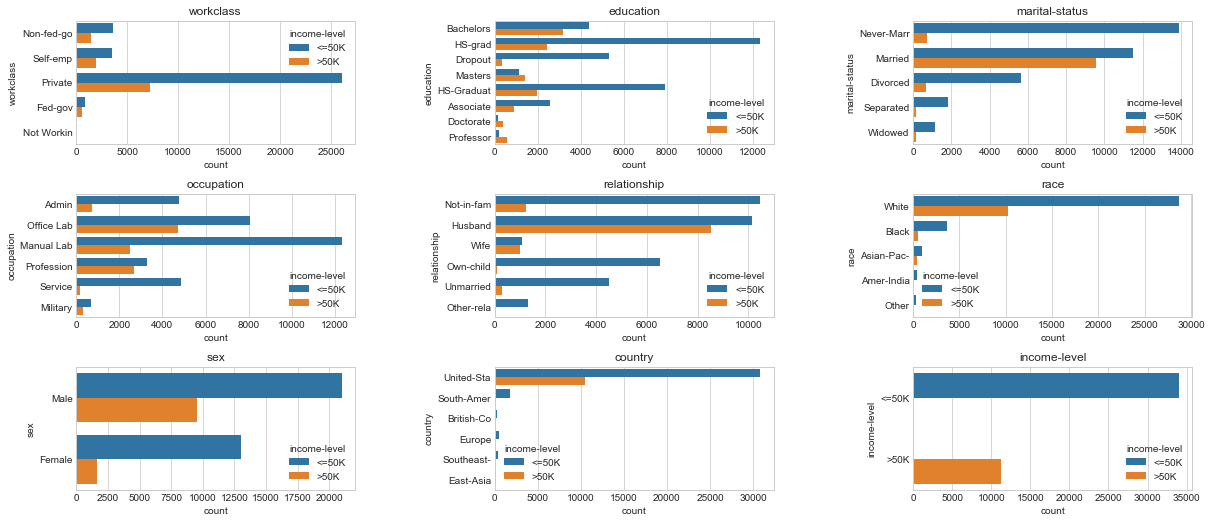

In [29]:
# 探索各分类变量对收入指标的影响
# 暂时不用这张表了
def plot_bivariate_bar(dataset, hue, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    i = 1
    for column in dataset.columns:
        if dataset.dtypes[column] == np.object:
            ax = fig.add_subplot(rows, cols, i)
            i = i + 1
            ax.set_title(column)
            g = sns.countplot(y=column, hue=hue, data=dataset)
            substrings = [s.get_text()[:10] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            
plot_bivariate_bar(dataset, hue='income-level', cols=3, width=20, height=15, hspace=0.4, wspace=0.5)

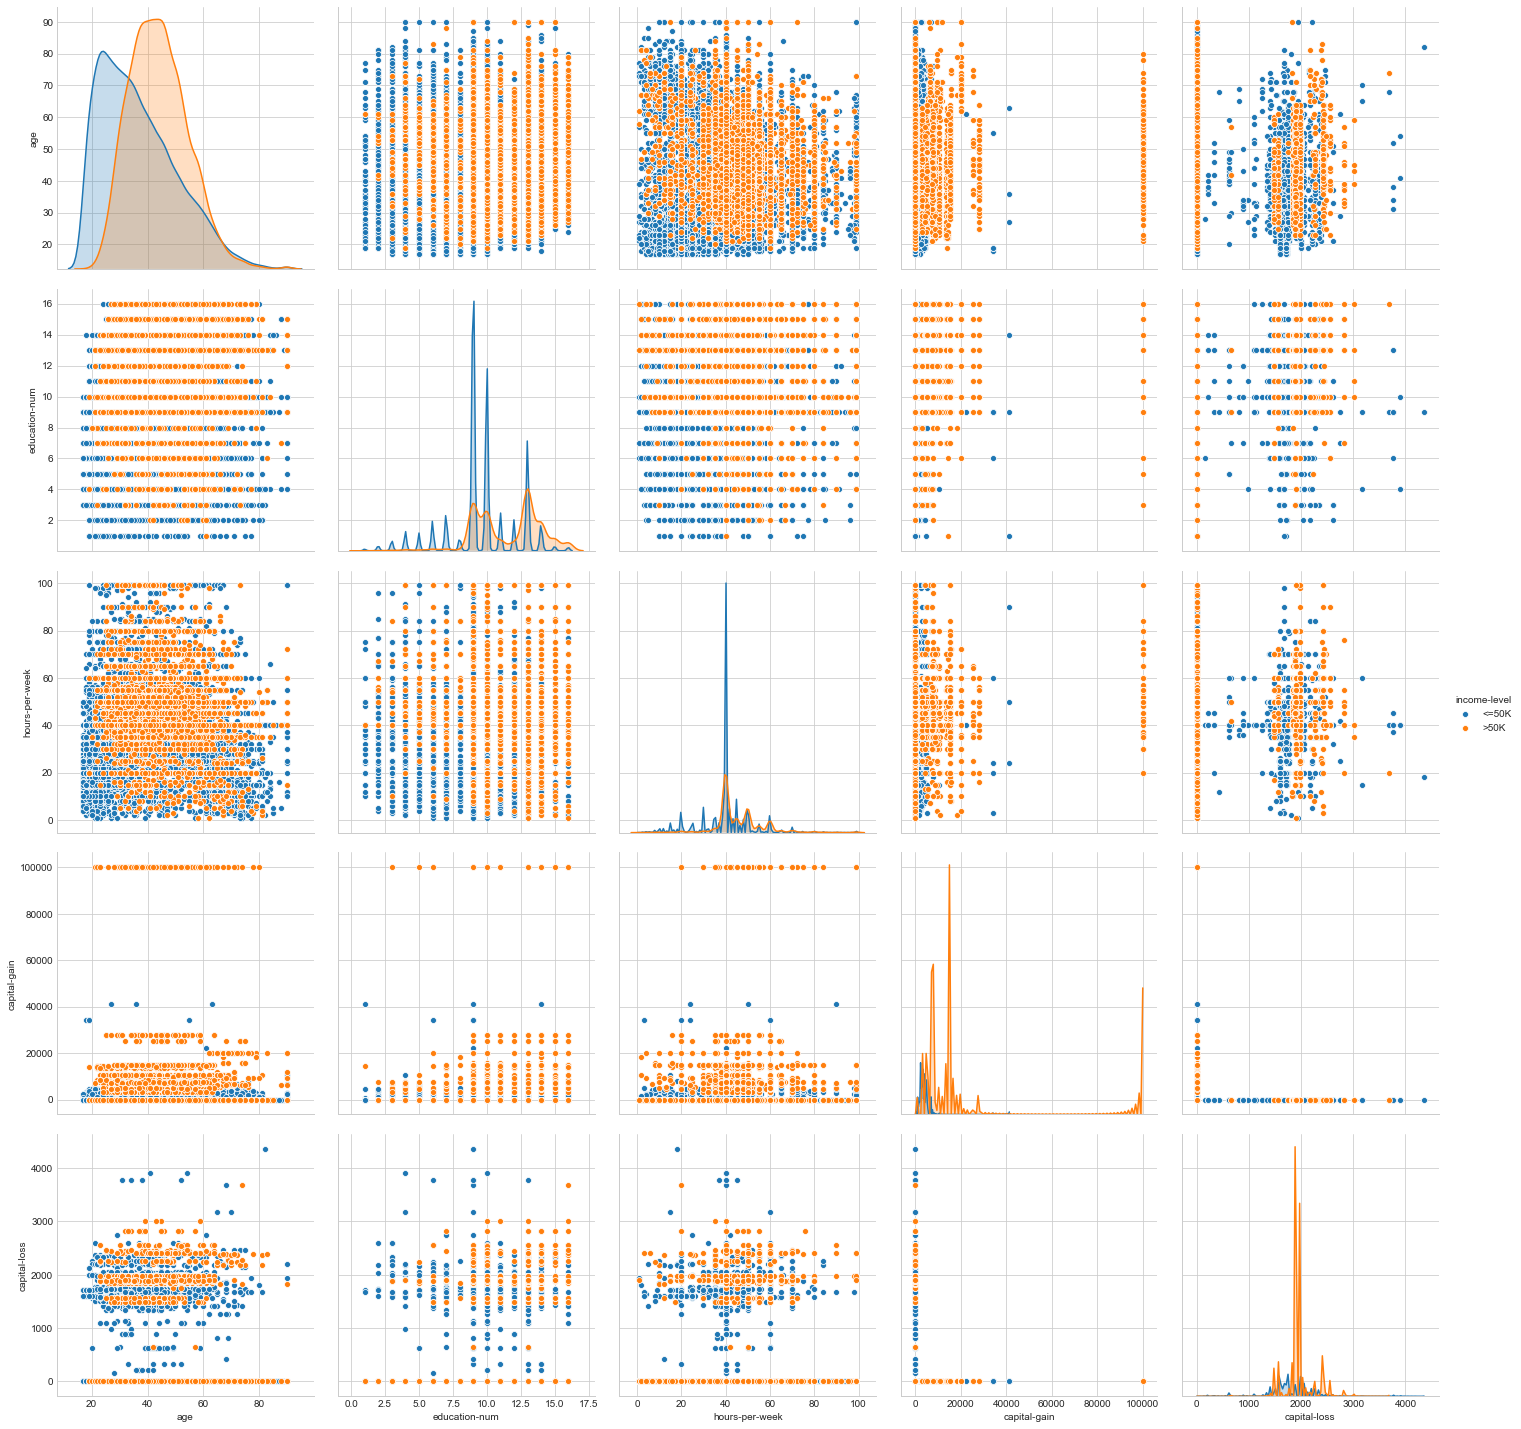

In [30]:
# 探索各连续型变量对收入指标的影响
# 暂时不用这张表
sns.pairplot(dataset[['age','education-num','hours-per-week','income-level','capital-gain','capital-loss']], 
             hue="income-level", 
             diag_kind="kde",
             size=4);

In [31]:
## 复制数据集，并将其中的离散字符串变量转化为数值型，以便进行相关分析
dataset_num = dataset.copy() # 复制数据集

dataset_num['workclass'] = dataset_num['workclass'].factorize()[0]
dataset_num['education'] = dataset_num['education'].factorize()[0]
dataset_num['marital-status'] = dataset_num['marital-status'].factorize()[0]
dataset_num['occupation'] = dataset_num['occupation'].factorize()[0]
dataset_num['relationship'] = dataset_num['relationship'].factorize()[0]
dataset_num['race'] = dataset_num['race'].factorize()[0]
dataset_num['sex'] = dataset_num['sex'].factorize()[0]
dataset_num['country'] = dataset_num['country'].factorize()[0]
dataset_num['income-level'] = dataset_num['income-level'].factorize()[0]


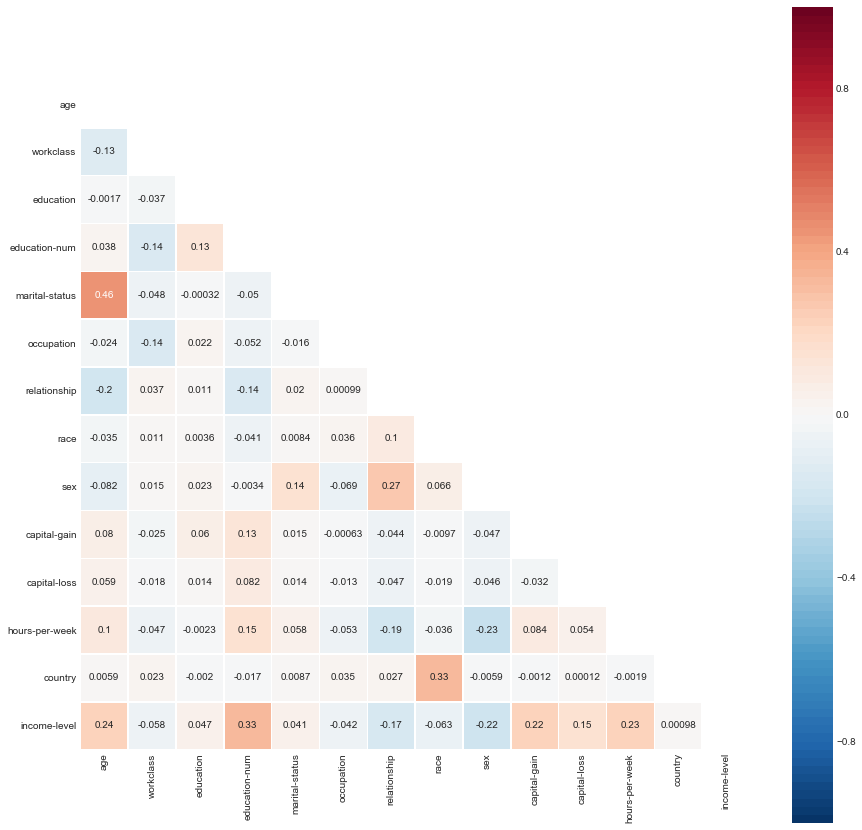

In [32]:
# 绘制相关性图谱，检查变量间的相关性
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(15, 15)) 

mask = np.zeros_like(dataset_num.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_num.corr(), vmin=-1, vmax=1, square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, annot=True, linewidths=.5);

通过相关分析可见，各变量间不存在较为明显的共线性，暂不对变量进行筛选

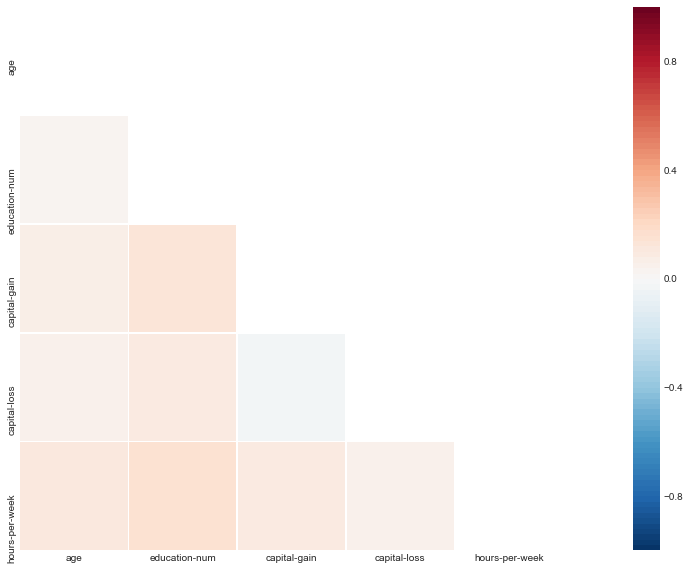

In [33]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,10)) 
mask = np.zeros_like(dataset.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

# 切分数据集

In [34]:
# 切分自变量和因变量
y_data=dataset_num['income-level']  # 取收入水平income-level列
x_data=dataset_num.drop(['income-level'],axis=1)  # 排除收入水平income-level列，剩下的列作为X_data

In [35]:
# 切分训练集和测试集
x_train,x_test,y_train,y_test = train_test_split(
    x_data,
    y_data,
    test_size=0.2,
    random_state=1,
    stratify=y_data) 


## 设置一个随机数种子

In [36]:
# random.seed(1)

# 构建分类器

## 构建分类器训练测试的通用函数

In [37]:
# 存取变量 - 便于模型跑死后中断重新载入已训练好的数据集，节约调试时间
import dill

# 存储 - 存储当前工作区变量
dill.dump_session('variables.pkl')

In [38]:
import dill
# 读取 - 读取当前工作区变量
dill.load_session('variables.pkl')

In [39]:
# 构建函数用于计算TPR(True Positive Rate)和FPR(False Positive Rate)并绘制ROC曲线
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

In [40]:
# 构造一个模型套用的样板，自动调用训练集对传入的模型进行训练，使用验证集对模型进行检验，并输出相关指标
def fit_ml_algo(algo, X_train, y_train, X_test, cv):
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    try:
        probs = model.predict_proba(X_test)[:,1]
    except Exception as e:
        probs = "Unavailable"
        print('Warning: Probs unavaliable.')
        print('Reason: ', e)
        
    
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs

In [41]:
# 汇报候选模型参数
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}\n".format(results['params'][candidate]))

In [42]:
# 构建绘制P-R曲线方法
def plot_pr_curve(y_test, probs):
    precision, recall, _ = precision_recall_curve(y_test, probs)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision_score(y_test, probs)))

## Logistic Regression

In [43]:
# Logistic回归 

# 设置超参数并构建随机搜索器           
n_iter_search = 10  # 训练10次，数值越大，获得的参数精度越大，但是搜索时间越长
param_dist = {'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}
random_search = RandomizedSearchCV(LogisticRegression(),   # 使用的分类器
                                   n_jobs=-1, # 使用所有的CPU进行训练，默认为1，使用1个CPU
                                   param_distributions=param_dist,  
                                   n_iter=n_iter_search) # 训练次数
start = time.time()
random_search.fit(x_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 78.67 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.789 (std: 0.003)
Parameters: {'penalty': 'l2', 'intercept_scaling': 4.2861089500154226e-20, 'class_weight': None, 'C': 0.1185515920962379}

Model with rank: 2
Mean validation score: 0.789 (std: 0.003)
Parameters: {'penalty': 'l2', 'intercept_scaling': 0.0022373553845475773, 'class_weight': None, 'C': 1554243829725976.5}

Model with rank: 3
Mean validation score: 0.762 (std: 0.004)
Parameters: {'penalty': 'l1', 'intercept_scaling': 0.03748498882741727, 'class_weight': 'balanced', 'C': 980616394868363.1}

Model with rank: 4
Mean validation score: 0.752 (std: 0.000)
Parameters: {'penalty': 'l1', 'intercept_scaling': 51.30633790483969, 'class_weight': None, 'C': 1.2156497940620604e-12}

Model with rank: 4
Mean validation score: 0.752 (std: 0.000)
Parameters: {'penalty': 'l1', 'intercept_scaling': 5.859718966860556e+18, 'class_weight': None, 'C': 1.138952600585518e-15}



In [44]:
# 调用随机搜索器得到的参数最优的Logistic回归模型进行训练，
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(
#                                                                  LogisticRegression(n_jobs = -1),
                                                                 random_search.best_estimator_, 
                                                                 x_train, 
                                                                 y_train, 
                                                                 x_test, 
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s s" % datetime.timedelta(seconds=log_time).seconds)

Accuracy: 79.1
Accuracy CV 10-Fold: 78.89
Running Time: 3 s


In [45]:
# 其中列表左边的一列为分类的标签名，右边support列为每个标签的出现次数．avg / total行为各列的均值（support列为总和）． 
# precision recall f1-score三列分别为各个类别的精确度/召回率及 F1 F1值．
# 训练集样本表现
print(metrics.classification_report(y_train, train_pred_log))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87     27211
           1       0.65      0.32      0.43      8966

    accuracy                           0.79     36177
   macro avg       0.73      0.63      0.65     36177
weighted avg       0.77      0.79      0.76     36177



In [46]:
# 测试集样本表现
print(metrics.classification_report(y_test, test_pred_log))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      6803
           1       0.66      0.32      0.43      2242

    accuracy                           0.79      9045
   macro avg       0.74      0.63      0.65      9045
weighted avg       0.77      0.79      0.76      9045



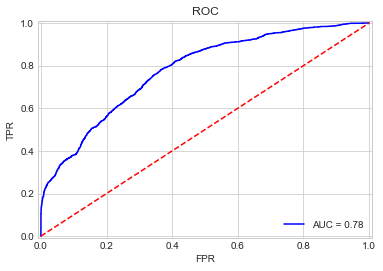

In [47]:
# 绘制ROC
plot_roc_curve(y_test, probs_log)

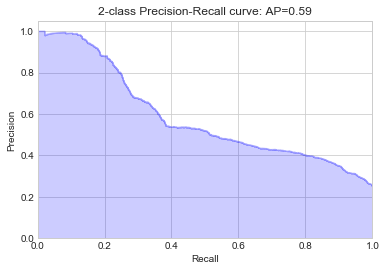

In [48]:
# 绘制P-R曲线
plot_pr_curve(y_test, probs_log)

## KNN

In [49]:
# k-Nearest Neighbors
start_time = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn\
= fit_ml_algo(KNeighborsClassifier(n_neighbors = 3,
                                   n_jobs = -1), 
                                   x_train, 
                                   y_train, 
                                   x_test, 
                                   10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s s" % datetime.timedelta(seconds=knn_time).seconds)

Accuracy: 82.74
Accuracy CV 10-Fold: 82.64
Running Time: 36 s


In [50]:
# 训练集样本表现
print(metrics.classification_report(y_train, train_pred_knn))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     27211
           1       0.66      0.63      0.64      8966

    accuracy                           0.83     36177
   macro avg       0.77      0.76      0.76     36177
weighted avg       0.82      0.83      0.83     36177



In [51]:
# 测试集样本表现
print(metrics.classification_report(y_test, test_pred_knn))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      6803
           1       0.66      0.64      0.65      2242

    accuracy                           0.83      9045
   macro avg       0.77      0.76      0.77      9045
weighted avg       0.83      0.83      0.83      9045



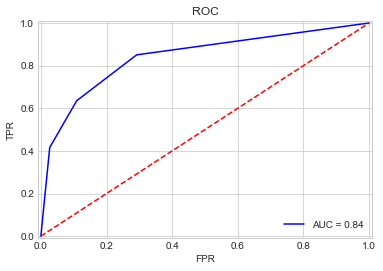

In [52]:
# 绘制ROC
plot_roc_curve(y_test, probs_knn)

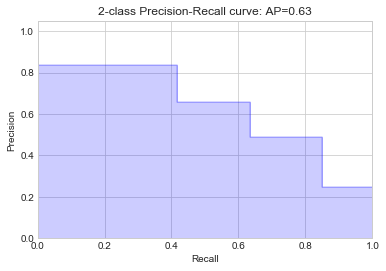

In [53]:
# 绘制P-R曲线
plot_pr_curve(y_test, probs_knn)

## Gaussian Naive Bayes

In [54]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gau\
= fit_ml_algo(GaussianNB(), 
              x_train, 
              y_train, 
              x_test, 
              10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s s" % datetime.timedelta(seconds=gaussian_time).seconds)

Accuracy: 80.19
Accuracy CV 10-Fold: 79.88
Running Time: 0 s


In [55]:
# 训练集样本表现
print(metrics.classification_report(y_train, train_pred_gaussian))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88     27211
           1       0.69      0.35      0.46      8966

    accuracy                           0.80     36177
   macro avg       0.75      0.65      0.67     36177
weighted avg       0.78      0.80      0.77     36177



In [56]:
# 测试集样本表现
print(metrics.classification_report(y_test, test_pred_gaussian)) 

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      6803
           1       0.70      0.35      0.47      2242

    accuracy                           0.80      9045
   macro avg       0.76      0.65      0.67      9045
weighted avg       0.79      0.80      0.78      9045



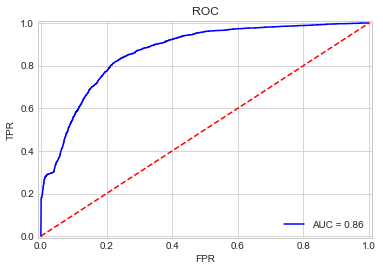

In [57]:
# 绘制ROC
plot_roc_curve(y_test, probs_gau)

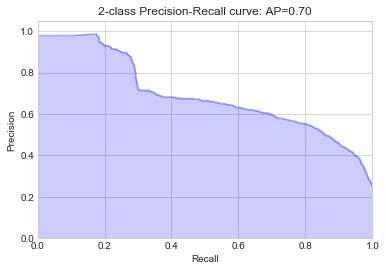

In [58]:
# 绘制P-R曲线
plot_pr_curve(y_test, probs_gau)

## Linear SVC

In [59]:
# Linear SVC
start_time = time.time()
# kernel = ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
svc_clf = SVC(probability=True, max_iter=1000, kernel='linear')
train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, probs_svc\
= fit_ml_algo(svc_clf,
              x_train, 
              y_train,
              x_test, 
              10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s s" % datetime.timedelta(seconds=linear_svc_time).seconds)

Accuracy: 53.29
Accuracy CV 10-Fold: 35.68
Running Time: 62 s


In [60]:
# 训练集样本表现
print(metrics.classification_report(y_train, train_pred_svc))

              precision    recall  f1-score   support

           0       0.68      0.28      0.39     27211
           1       0.21      0.59      0.31      8966

    accuracy                           0.36     36177
   macro avg       0.44      0.44      0.35     36177
weighted avg       0.56      0.36      0.37     36177



In [61]:
# 测试集样本表现
print(metrics.classification_report(y_test, test_pred_svc))

              precision    recall  f1-score   support

           0       0.79      0.52      0.63      6803
           1       0.28      0.58      0.38      2242

    accuracy                           0.53      9045
   macro avg       0.54      0.55      0.50      9045
weighted avg       0.66      0.53      0.56      9045



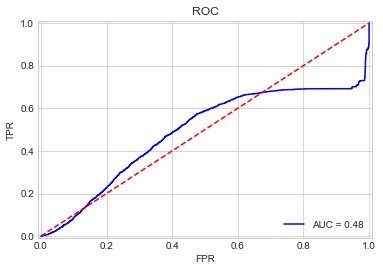

In [62]:
# 绘制ROC
plot_roc_curve(y_test, probs_svc)

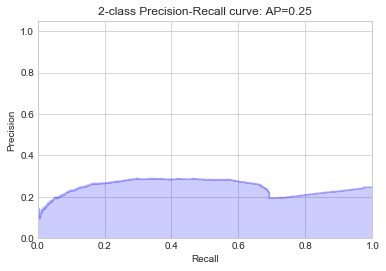

In [63]:
# 绘制P-R曲线
plot_pr_curve(y_test, probs_svc)

## Stochastic Gradient Descent

In [64]:
# Stochastic Gradient Descent 随机梯度下降
start_time = time.time()
train_pred_sgd, test_pred_sgd, acc_sgd, acc_cv_sgd, probs_sgd\
= fit_ml_algo(
              SGDClassifier(n_jobs = -1, loss='log'), 
              x_train, 
              y_train, 
              x_test, 
              10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s s" % datetime.timedelta(seconds=sgd_time).seconds)

Accuracy: 77.06
Accuracy CV 10-Fold: 76.66
Running Time: 2 s


In [65]:
# 训练集样本表现
print(metrics.classification_report(y_train, train_pred_sgd)) 

              precision    recall  f1-score   support

           0       0.83      0.87      0.85     27211
           1       0.53      0.46      0.49      8966

    accuracy                           0.77     36177
   macro avg       0.68      0.66      0.67     36177
weighted avg       0.76      0.77      0.76     36177



In [66]:
# 测试集样本表现
print(metrics.classification_report(y_test, test_pred_sgd)) 

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      6803
           1       0.53      0.62      0.57      2242

    accuracy                           0.77      9045
   macro avg       0.70      0.72      0.71      9045
weighted avg       0.78      0.77      0.78      9045



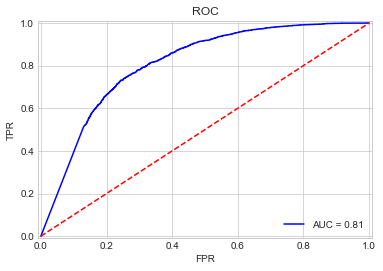

In [67]:
# 绘制ROC
plot_roc_curve(y_test, probs_sgd)

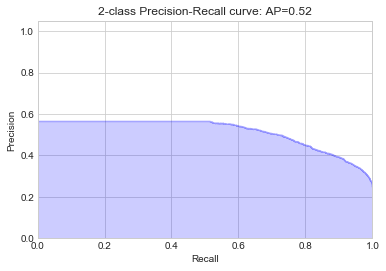

In [68]:
# 绘制P-R曲线
plot_pr_curve(y_test, probs_sgd)

## Decision Tree Classifier

In [69]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt\
= fit_ml_algo(DecisionTreeClassifier(), 
              x_train, 
              y_train, 
              x_test, 
              10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s s" % datetime.timedelta(seconds=dt_time).seconds)

Accuracy: 82.1
Accuracy CV 10-Fold: 81.68
Running Time: 1 s


In [70]:
# 训练集样本表现
print(metrics.classification_report(y_train, train_pred_dt)) 

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     27211
           1       0.64      0.60      0.62      8966

    accuracy                           0.82     36177
   macro avg       0.75      0.75      0.75     36177
weighted avg       0.81      0.82      0.82     36177



In [71]:
# 测试集样本表现
print(metrics.classification_report(y_test, test_pred_dt)) 

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      6803
           1       0.65      0.61      0.63      2242

    accuracy                           0.82      9045
   macro avg       0.76      0.75      0.76      9045
weighted avg       0.82      0.82      0.82      9045



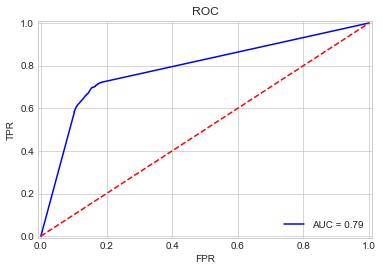

In [72]:
# 绘制ROC
plot_roc_curve(y_test, probs_dt)

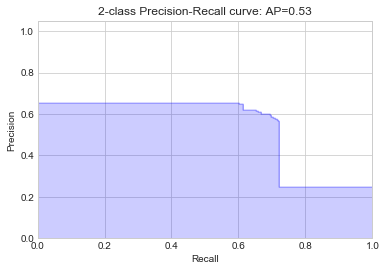

In [73]:
# 绘制P-R曲线
plot_pr_curve(y_test, probs_dt)

## Random Forest Classifier

In [74]:
# Random Forest Classifier - Random Search for Hyperparameters

# Utility function to report best scores
# def report(results, n_top=5):
#     for i in range(1, n_top + 1):
#         candidates = np.flatnonzero(results['rank_test_score'] == i)
#         for candidate in candidates:
#             print("Model with rank: {0}".format(i))
#             print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
#                   results['mean_test_score'][candidate],
#                   results['std_test_score'][candidate]))
#             print("Parameters: {0}\n".format(results['params'][candidate]))
            
# 从中调参的超参数集合
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Run Randomized Search
n_iter_search = 10
random_search = RandomizedSearchCV(
                                   RandomForestClassifier(n_estimators=10),
                                   n_jobs = -1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(x_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 5.81 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.857 (std: 0.001)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 4, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.856 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 6, 'min_samples_split': 12}

Model with rank: 3
Mean validation score: 0.856 (std: 0.001)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 9, 'min_samples_leaf': 9, 'min_samples_split': 18}

Model with rank: 4
Mean validation score: 0.855 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 9, 'min_samples_leaf': 4, 'min_samples_split': 2}

Model with rank: 5
Mean validation score: 0.855 (std: 0.000)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max

In [75]:

# rfc = RandomForestClassifier(n_estimators=10, 
#                              min_samples_leaf=2,
#                              min_samples_split=17, 
#                              criterion='gini', 
#                              max_features=8)
# Random Forest Classifier
# 使用随机搜索器算得的最优超参数模型进行计算
start_time = time.time()
rfc = random_search.best_estimator_
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(
                                                             rfc, 
                                                             x_train, 
                                                             y_train, 
                                                             x_test, 
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s s" % datetime.timedelta(seconds=rf_time).seconds)

Accuracy: 86.2
Accuracy CV 10-Fold: 85.74
Running Time: 3 s


In [76]:
# 测试集样本表现
print(metrics.classification_report(y_train, train_pred_rf)) 

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     27211
           1       0.77      0.60      0.68      8966

    accuracy                           0.86     36177
   macro avg       0.83      0.77      0.79     36177
weighted avg       0.85      0.86      0.85     36177



In [77]:
# 训练集样本表现
print(metrics.classification_report(y_test, test_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      6803
           1       0.79      0.61      0.69      2242

    accuracy                           0.86      9045
   macro avg       0.83      0.78      0.80      9045
weighted avg       0.86      0.86      0.86      9045



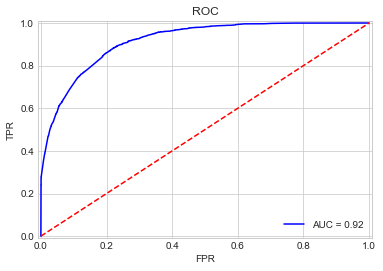

In [78]:
# 绘制ROC
plot_roc_curve(y_test, probs_rf)

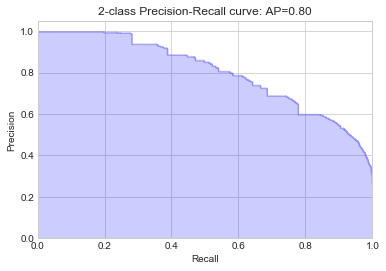

In [79]:
# 绘制P-R曲线
plot_pr_curve(y_test, probs_rf)

## Gradient Boosting Trees

In [80]:
# Gradient Boosting Trees 梯度提升决策树
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt\
= fit_ml_algo(GradientBoostingClassifier(), 
              x_train, 
              y_train, 
              x_test, 
              10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s s" % datetime.timedelta(seconds=gbt_time).seconds)

Accuracy: 86.19
Accuracy CV 10-Fold: 85.97
Running Time: 19 s


In [81]:
# 训练集样本表现
print(metrics.classification_report(y_train, train_pred_gbt)) 

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     27211
           1       0.79      0.59      0.68      8966

    accuracy                           0.86     36177
   macro avg       0.83      0.77      0.79     36177
weighted avg       0.85      0.86      0.85     36177



In [82]:
# 测试集样本表现
print(metrics.classification_report(y_test, test_pred_gbt)) 

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6803
           1       0.81      0.58      0.68      2242

    accuracy                           0.86      9045
   macro avg       0.84      0.77      0.79      9045
weighted avg       0.86      0.86      0.85      9045



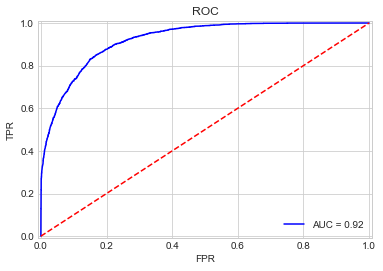

In [83]:
# 绘制ROC
plot_roc_curve(y_test, probs_gbt)

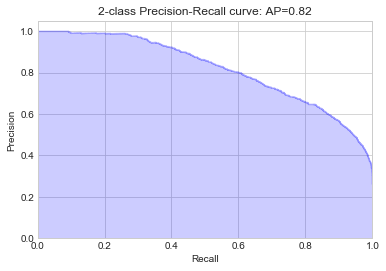

In [84]:
# 绘制P-R曲线
plot_pr_curve(y_test, probs_gbt)

## AdaBoost

In [85]:
# AdaBoost Classifier
start_time = time.time()
train_pred_adb, test_pred_adb, acc_adb, acc_cv_adb, probs_adb\
= fit_ml_algo(AdaBoostClassifier(), 
              x_train, 
              y_train, 
              x_test, 
              10)
adb_time = (time.time() - start_time)
print("Accuracy: %s" % acc_adb)
print("Accuracy CV 10-Fold: %s" % acc_cv_adb)
print("Running Time: %s s" % datetime.timedelta(seconds=adb_time).seconds)

Accuracy: 85.86
Accuracy CV 10-Fold: 85.41
Running Time: 7 s


In [86]:
# 训练集样本表现
print(metrics.classification_report(y_train, train_pred_adb)) 

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     27211
           1       0.76      0.61      0.67      8966

    accuracy                           0.85     36177
   macro avg       0.82      0.77      0.79     36177
weighted avg       0.85      0.85      0.85     36177



In [87]:
# 测试集样本表现
print(metrics.classification_report(y_test, test_pred_adb)) 

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6803
           1       0.77      0.62      0.68      2242

    accuracy                           0.86      9045
   macro avg       0.82      0.78      0.80      9045
weighted avg       0.85      0.86      0.85      9045



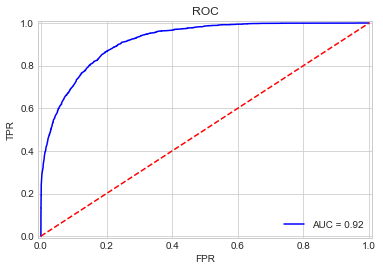

In [88]:
# 绘制ROC
plot_roc_curve(y_test, probs_adb)

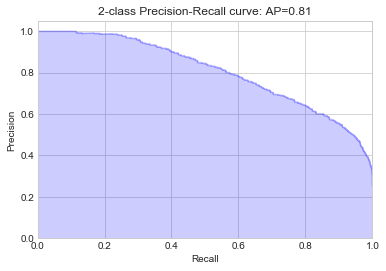

In [89]:
# 绘制P-R曲线
plot_pr_curve(y_test, probs_adb)

## VotingClassifier

In [90]:
# Voting Classifier
start_time = time.time()
voting_clf = VotingClassifier(estimators=[
    ('log_clf', LogisticRegression()), 
    ('gnb_clf', GaussianNB()),
    ('rf_clf', RandomForestClassifier(n_estimators=10)),
    ('gb_clf', GradientBoostingClassifier()),
    ('dt_clf', DecisionTreeClassifier(random_state=666))],
                             voting='soft', n_jobs = -1)
train_pred_vot, test_pred_vot, acc_vot, acc_cv_vot, probs_vot\
= fit_ml_algo(voting_clf, 
              x_train, 
              y_train, 
              x_test, 
              10)
vot_time = (time.time() - start_time)
print("Accuracy: %s" % acc_vot)
print("Accuracy CV 10-Fold: %s" % acc_cv_vot)
print("Running Time: %s s" % datetime.timedelta(seconds=vot_time).seconds)

Accuracy: 84.94
Accuracy CV 10-Fold: 84.75
Running Time: 24 s


In [91]:
# 训练集样本表现
print(metrics.classification_report(y_train, train_pred_vot)) 

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     27211
           1       0.78      0.53      0.63      8966

    accuracy                           0.85     36177
   macro avg       0.82      0.74      0.77     36177
weighted avg       0.84      0.85      0.84     36177



In [92]:
# 测试集样本表现
print(metrics.classification_report(y_test, test_pred_vot)) 

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      6803
           1       0.79      0.54      0.64      2242

    accuracy                           0.85      9045
   macro avg       0.82      0.74      0.77      9045
weighted avg       0.84      0.85      0.84      9045



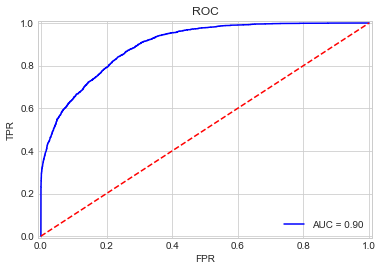

In [93]:
# 绘制ROC
plot_roc_curve(y_test, probs_vot)

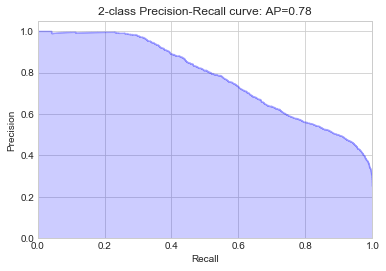

In [94]:
# 绘制P-R曲线
plot_pr_curve(y_test, probs_vot)

# 结果排序

In [95]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees', 
              'AdaBoost', 'Voting'],
    'Acc': [
        acc_knn, acc_log, acc_rf, 
        acc_gaussian, acc_sgd, 
        acc_linear_svc, acc_dt,
        acc_gbt, acc_adb, acc_vot
    ],
    'Acc_cv': [
        acc_cv_knn, acc_cv_log, 
        acc_cv_rf, acc_cv_gaussian, 
        acc_cv_sgd, acc_cv_linear_svc, 
        acc_cv_dt, acc_cv_gbt,
        acc_cv_adb, acc_cv_vot
    ],
    'precision': [
        round(precision_score(y_test,test_pred_knn), 3),
        round(precision_score(y_test,test_pred_log), 3),
        round(precision_score(y_test,test_pred_rf), 3),
        round(precision_score(y_test,test_pred_gaussian), 3),
        round(precision_score(y_test,test_pred_sgd), 3),
        round(precision_score(y_test,test_pred_svc), 3),
        round(precision_score(y_test,test_pred_dt), 3),
        round(precision_score(y_test,test_pred_gbt), 3),
        round(precision_score(y_test,test_pred_adb), 3),
        round(precision_score(y_test,test_pred_vot), 3),  
    ],
    'recall': [
        round(recall_score(y_test,test_pred_knn), 3),
        round(recall_score(y_test,test_pred_log), 3),
        round(recall_score(y_test,test_pred_rf), 3),
        round(recall_score(y_test,test_pred_gaussian), 3),
        round(recall_score(y_test,test_pred_sgd), 3),
        round(recall_score(y_test,test_pred_svc), 3),
        round(recall_score(y_test,test_pred_dt), 3),
        round(recall_score(y_test,test_pred_gbt), 3),
        round(recall_score(y_test,test_pred_adb), 3),
        round(recall_score(y_test,test_pred_vot), 3),  
    ],
    'F1': [
        round(f1_score(y_test,test_pred_knn,average='binary'), 3),
        round(f1_score(y_test,test_pred_log,average='binary'), 3),
        round(f1_score(y_test,test_pred_rf,average='binary'), 3),
        round(f1_score(y_test,test_pred_gaussian,average='binary'), 3),
        round(f1_score(y_test,test_pred_sgd,average='binary'), 3),
        round(f1_score(y_test,test_pred_svc,average='binary'), 3),
        round(f1_score(y_test,test_pred_dt,average='binary'), 3),
        round(f1_score(y_test,test_pred_gbt,average='binary'), 3),
        round(f1_score(y_test,test_pred_adb,average='binary'), 3),
        round(f1_score(y_test,test_pred_vot,average='binary'), 3),    
    ],
})
models.sort_values(by='Acc', ascending=False)

,Model,Acc,Acc_cv,precision,recall,F1
2,Random Forest,86.20,85.74,0.786,0.609,0.686
7,Gradient Boosting Trees,86.19,85.97,0.808,0.581,0.676
8,AdaBoost,85.86,85.41,0.766,0.618,0.684
9,Voting,84.94,84.75,0.788,0.537,0.639
0,KNN,82.74,82.64,0.657,0.636,0.646
6,Decision Tree,82.10,81.68,0.647,0.612,0.629
3,Naive Bayes,80.19,79.88,0.702,0.349,0.466
1,Logistic Regression,79.10,78.89,0.665,0.317,0.429
4,Stochastic Gradient Decent,77.06,76.66,0.532,0.622,0.573
5,Linear SVC,53.29,35.68,0.283,0.576,0.379


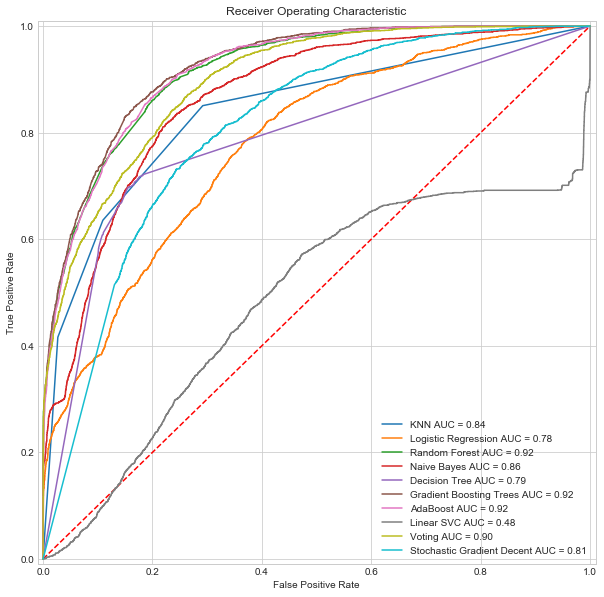

In [96]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10)) 
models = [
    'KNN', 
    'Logistic Regression', 
    'Random Forest', 
    'Naive Bayes', 
    'Decision Tree', 
    'Gradient Boosting Trees',
    'AdaBoost',
    'Linear SVC',
    'Voting',
    'Stochastic Gradient Decent'
]
probs = [
    probs_knn,
    probs_log,
    probs_rf,
    probs_gau,
    probs_dt,
    probs_gbt,
    probs_adb,
    probs_svc,
    probs_vot,
    probs_sgd
]
colormap = plt.cm.tab10 #nipy_spectral, Set1, Paired, tab10, gist_ncar
colors = [colormap(i) for i in np.linspace(0, 1,len(models))]
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
def plot_roc_curves(y_test, prob, model):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    label = model + ' AUC = %0.2f' % roc_auc
    plt.plot(fpr, tpr, 'b', label=label, color=colors[i])
    plt.legend(loc = 'lower right')  
for i, model in list(enumerate(models)):
    plot_roc_curves(y_test, probs[i], models[i])

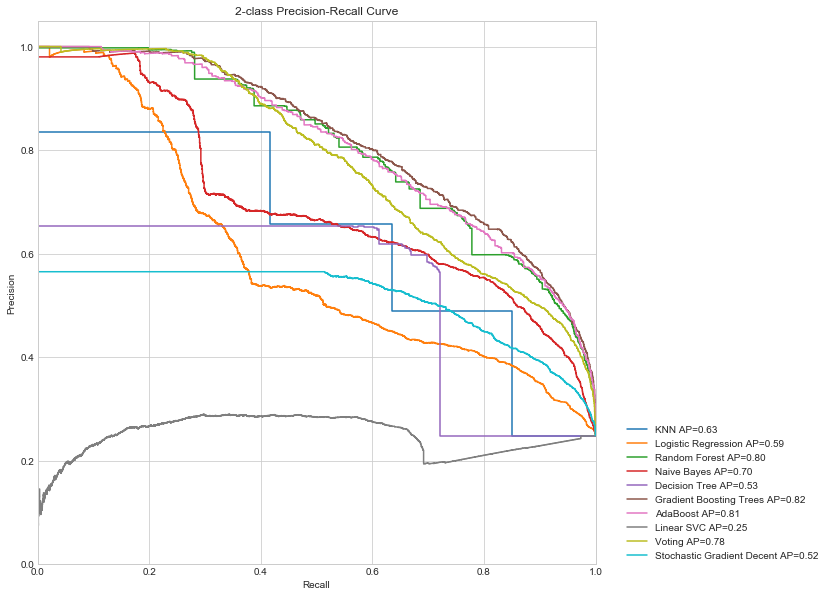

In [97]:
# 构建绘制P-R曲线方法  
fig = plt.figure(figsize=(10,10)) 
plt.xlabel('Recall')  
plt.ylabel('Precision')  
plt.ylim([0.0, 1.05])  
plt.xlim([0.0, 1.0]) 
plt.title('2-class Precision-Recall Curve')
colormap = plt.cm.tab10 #nipy_spectral, Set1, Paired, gist_ncar
colors = [colormap(i) for i in np.linspace(0, 1,len(models))]
def plot_pr_curve_overall(y_test, probs, model):  
    precision, recall, _ = precision_recall_curve(y_test, probs)  
    label = (model + ' AP={0:0.2f}'.format(average_precision_score(y_test, probs)))
    plt.step(recall, precision, color=colors[i],   
             where='post', label=label)  
#     plt.fill_between(recall, precision, step='post', alpha=0.2, color=colors[i])  
    plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0) 
for i, model in list(enumerate(models)):
    plot_pr_curve_overall(y_test, probs[i], models[i])